### This notebook comprises three sections:
### * Data Cleaning
### * Data Visualization
### * Machine Learning/Prediction

In [1]:
library(tidyverse)
library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)

# Data Importation:
library(readr)

# Summaries of Data:
library(skimr)

# Predictive Modeling/ML:
library(caret)
library(e1071)

# ROC curve:
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
foodpref <- read_csv("../input/food-preferences/Food_Preference.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  Timestamp = col_character(),
  Participant_ID = col_character(),
  Gender = col_character(),
  Nationality = col_character(),
  Age = col_double(),
  Food = col_character(),
  Juice = col_character(),
  Dessert = col_character()
)




# Data Cleaning

In [3]:
# Examine the structure of the df:
str(foodpref)

tibble [288 × 8] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Timestamp     : chr [1:288] "2019/05/07 2:59:13 PM GMT+8" "2019/05/07 2:59:45 PM GMT+8" "2019/05/07 3:00:05 PM GMT+8" "2019/05/07 3:00:11 PM GMT+8" ...
 $ Participant_ID: chr [1:288] "FPS001" "FPS002" "FPS003" "FPS004" ...
 $ Gender        : chr [1:288] "Male" "Female" "Male" "Female" ...
 $ Nationality   : chr [1:288] "Indian" "Indian" "Indian" "Indian" ...
 $ Age           : num [1:288] 24 22 31 25 27 24 34 24 19 16 ...
 $ Food          : chr [1:288] "Traditional food" "Western Food" "Western Food" "Traditional food" ...
 $ Juice         : chr [1:288] "Fresh Juice" "Carbonated drinks" "Fresh Juice" "Fresh Juice" ...
 $ Dessert       : chr [1:288] "Maybe" "Yes" "Maybe" "Maybe" ...
 - attr(*, "spec")=
  .. cols(
  ..   Timestamp = col_character(),
  ..   Participant_ID = col_character(),
  ..   Gender = col_character(),
  ..   Nationality = col_character(),
  ..   Age = col_double(),
  ..   Food = col_character(),
  ..   Juice

In [4]:
# Check for duplicate Participant_IDs:
sum(duplicated(foodpref$Participant_ID) == TRUE)

[1] 0

No duplicate Participant_IDs are present.

In [5]:
# Delete Participant_ID column and Timestamp columns; they are unneeded.
foodpref <- foodpref[, c(-1, -2)]

In [6]:
# Examine summary data:
skim(foodpref)

── Data Summary ────────────────────────
                           Values  
Name                       foodpref
Number of rows             288     
Number of columns          6       
_______________________            
Column type frequency:             
  character                5       
  numeric                  1       
________________________           
Group variables            None    

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate   min   max empty n_unique whitespace
1 Gender                4         0.986     4     6     0        2          0
2 Nationality           0         1         2    11     0       22          0
3 Food                  0         1        12    16     0        2          0
4 Juice                 0         1        11    17     0        2          0
5 Dessert               0         1         2     5     0        3          0

── Variable type: numeric ──────────────────────

The **Gender** column contains 4 NA entries, according to the summary. 
Check to see which rows in the dataframe contain NAs:

In [7]:
foodpref[!complete.cases(foodpref),]

Gender,Nationality,Age,Food,Juice,Dessert
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
NA,Muslim,27,Traditional food,Fresh Juice,Yes
NA,Indian,30,Traditional food,Fresh Juice,Yes
NA,Indian,23,Traditional food,Fresh Juice,Yes
NA,Indian,26,Traditional food,Fresh Juice,Yes


This confirms that all the NAs are in the **Gender** column.
Delete the rows containing NAs:

In [8]:
foodpref <- na.omit(foodpref)

In [9]:
# See which Nationalities are represented:
as.matrix(unique(foodpref$Nationality))

Indian
Pakistani
Tanzanian
Indonesia
Pakistan
Maldivian
MY
Malaysian
Indonesian
MALAYSIAN
Malaysia


Some of the names in the **Nationality** column are misspelled or otherwise inconsistent. 

Let's make them consistent:

In [10]:
foodpref$Nationality <- gsub("Malaysia", "Malaysian", foodpref$Nationality)
foodpref$Nationality <- gsub("MALAYSIAN", "Malaysian", foodpref$Nationality)
foodpref$Nationality <- gsub("Malaysiann", "Malaysian", foodpref$Nationality)
foodpref$Nationality <- gsub("MY", "Malaysian", foodpref$Nationality)

foodpref$Nationality <- gsub("Indonesain", "Indonesian", foodpref$Nationality)
foodpref$Nationality <- gsub("Indonesia", "Indonesian", foodpref$Nationality)
foodpref$Nationality <- gsub("Indonesiann", "Indonesian", foodpref$Nationality)

foodpref$Nationality <- gsub("Pakistan", "Pakistani", foodpref$Nationality)
foodpref$Nationality <- gsub("Pakistanii", "Pakistani", foodpref$Nationality)

View the counts for each nationality:

In [11]:
foodpref %>% count(Nationality, sort = TRUE)

Nationality,n
<chr>,<int>
Indian,238
Malaysian,16
Indonesian,10
Pakistani,6
Maldivian,3
Japan,2
Algerian,1
Canadian,1
China,1


Very few of the records correspond to non-Indian nationalities. Due to the severe class imbalance, we will consolidate these other nationalities into a single 'Non_Indian' class later on.

## Data Visualization

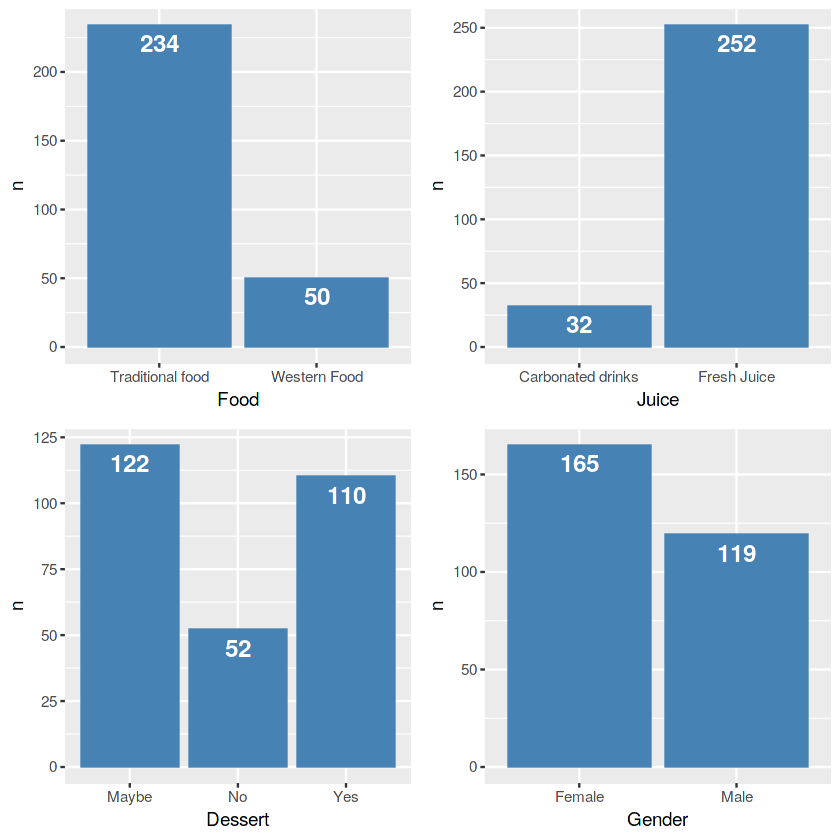

In [12]:
# # Let's graph the totals for the other categorical variables:

foodpref %>% count(Food, sort = TRUE) -> Food_count
Food_count %>% ggplot(aes(x = Food, y = n)) + geom_bar(stat = "identity") + geom_bar(stat = "identity", color = "steelblue", fill = "steelblue") + geom_text(aes(label=n), color="white", fontface = "bold", vjust = 1.5, size=5) -> Food_count_g

foodpref %>% count(Juice, sort = TRUE) -> Juice_count
Juice_count %>% ggplot(aes(x = Juice, y = n)) + geom_bar(stat = "identity") + geom_bar(stat = "identity", color = "steelblue", fill = "steelblue") + geom_text(aes(label=n), color="white", fontface = "bold", vjust = 1.5, size=5) -> Juice_count_g

foodpref %>% count(Dessert, sort = TRUE) -> Dessert_count
Dessert_count %>% ggplot(aes(x = Dessert, y = n)) + geom_bar(stat = "identity") + geom_bar(stat = "identity", color = "steelblue", fill = "steelblue") + geom_text(aes(label=n), color="white", fontface = "bold", vjust = 1.5, size=5) -> Dessert_count_g

foodpref %>% count(Gender, sort = TRUE) -> Gender_count
Gender_count %>% ggplot(aes(x = Gender, y = n)) + geom_bar(stat = "identity", color = "steelblue", fill = "steelblue") + geom_text(aes(label=n), color="white", fontface = "bold", vjust = 1.5, size=5) -> Gender_count_g

grid.arrange(Food_count_g, Juice_count_g, Dessert_count_g, Gender_count_g)

Some of the choices are far more popular than others -- e.g., *fresh juice vs carbonated drinks*.

Is **Dessert** more or less popular in the context of certain **Food** and **Juice** preferences? Let's examine normalized dessert data:

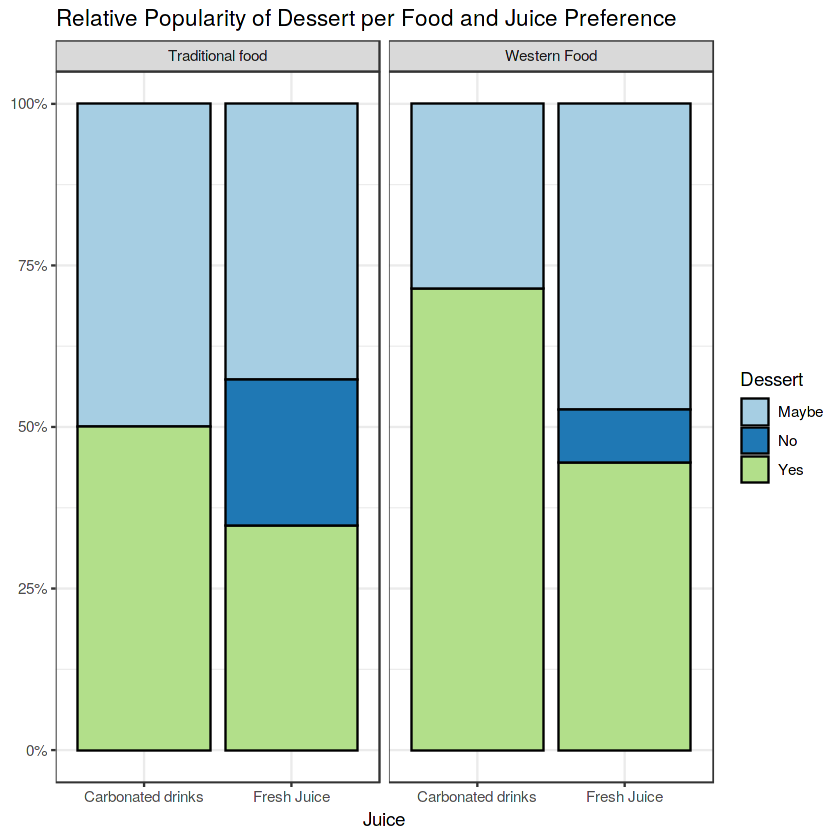

In [13]:
summary1 <- foodpref %>%
        count(Food, Juice, Dessert, sort = TRUE)

ggplot(summary1, aes(Juice, n, fill = Dessert)) + 
        geom_bar(position = "fill" , stat = "identity", color = "black") +
        facet_wrap(facets = vars(Food)) +
        scale_fill_brewer(palette="Paired") +
        theme_bw() + scale_y_continuous(labels = scales::percent) +
        ggtitle("Relative Popularity of Dessert per Food and Juice Preference") +
        labs(y = NULL)

Let's examine the popularity of each food preference by **gender**:

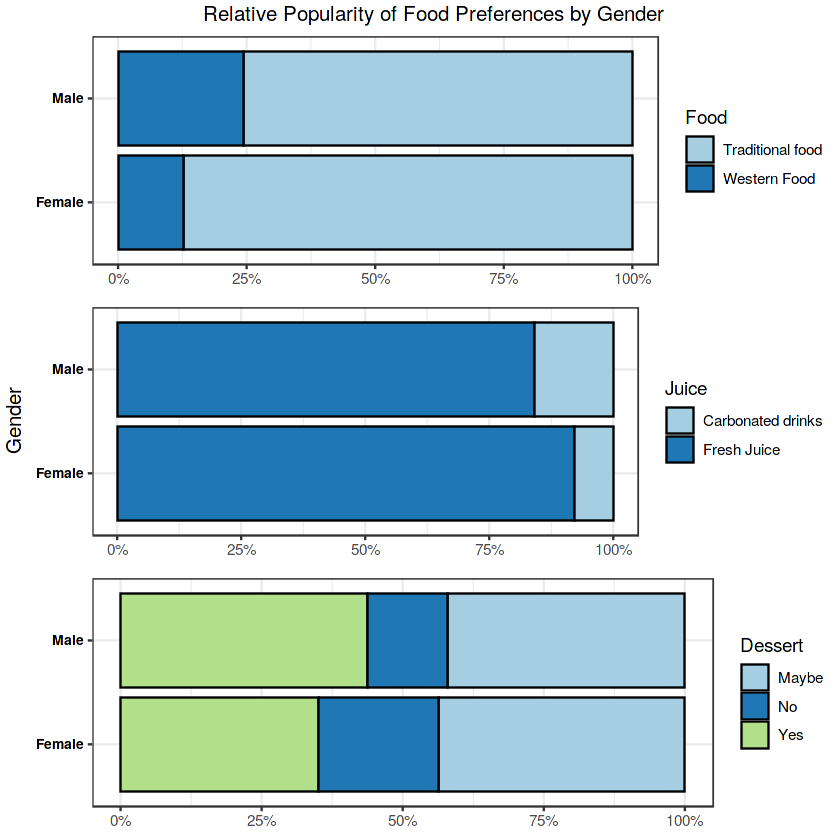

In [14]:
Food_summary <- foodpref %>%
        count(Gender, Food, sort = TRUE)

Food_plot <- ggplot(Food_summary, aes(Gender, n, fill = Food)) +
        geom_bar(position = "fill" , stat = "identity", color = "black") +
        theme_bw() + coord_flip() +
        scale_fill_brewer(palette="Paired") +
        theme(axis.text.y = (element_text(hjust = 1, face = "bold", 
                                          color = "black", size = 8))) +
        labs(x = NULL, y = NULL) + scale_y_continuous(labels = scales::percent)

Dessert_summary <- foodpref %>%
        count(Gender, Dessert, sort = TRUE)

Dessert_plot <- ggplot(Dessert_summary, aes(Gender, n, fill = Dessert)) +
        geom_bar(position = "fill" , stat = "identity", color = "black") +
        theme_bw() + coord_flip() +         
        scale_fill_brewer(palette="Paired") +
        theme(axis.text.y = (element_text(hjust = 1, face = "bold", 
                                          color = "black", size = 8))) +
        labs(x = NULL, y = NULL) + scale_y_continuous(labels = scales::percent)

Juice_summary <- foodpref %>%
        count(Gender, Juice, sort = TRUE)

Juice_plot <- ggplot(Juice_summary, aes(Gender, n, fill = Juice)) +
        geom_bar(position = "fill" , stat = "identity", color = "black") +
       coord_flip() + theme_bw() + 
        scale_fill_brewer(palette="Paired") +
        theme(axis.text.y = (element_text(hjust = 1, face = "bold", 
                                          color = "black", size = 8))) +
        labs(x = NULL, y = NULL) + scale_y_continuous(labels = scales::percent)

grid.arrange(nrow = 3, ncol = 1, top = "Relative Popularity of Food Preferences by Gender", left = "Gender",
             Food_plot, 
             Juice_plot,
             Dessert_plot)

Let's graph **age** data in the context of food preferences:

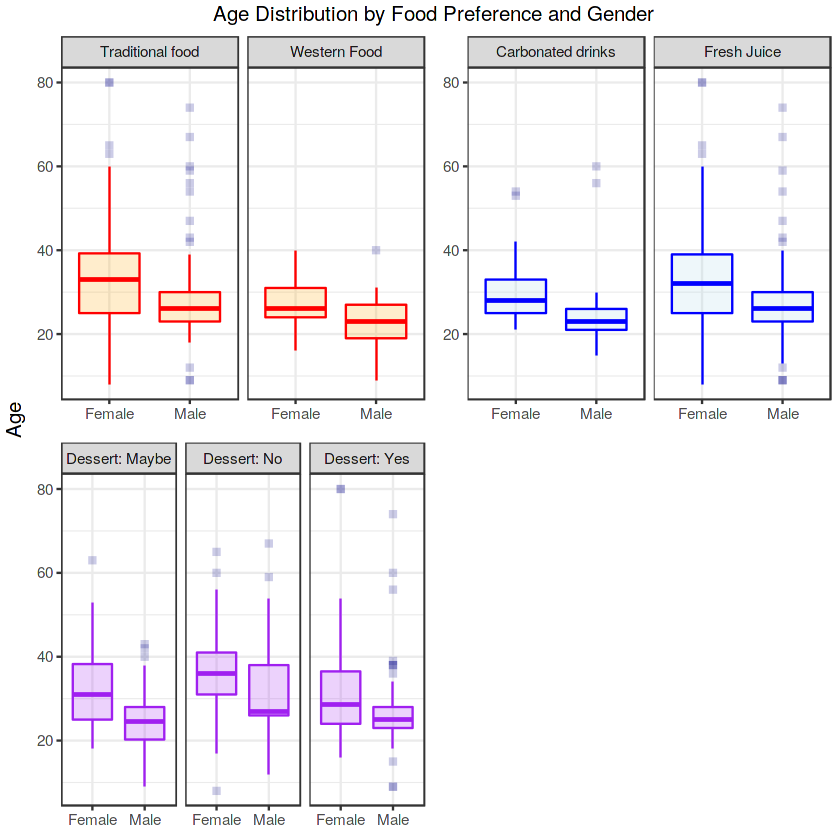

In [15]:
Food_Age_P <- ggplot(foodpref, aes(x = Gender, y = Age, fill = Gender)) + 
        geom_boxplot(outlier.size=2,outlier.shape=15,outlier.colour="darkblue",
                     color="red", fill="orange", alpha=0.2) +
        facet_wrap(facets = vars(Food)) + scale_fill_brewer(palette = "Dark2") + 
        theme_bw() + labs(x = NULL, y = NULL)

Juice_Age_P <- ggplot(foodpref, aes(x = Gender, y = Age, fill = Gender)) + 
        geom_boxplot(outlier.size=2,outlier.shape=15,outlier.colour="darkblue",
                     color="blue", fill="lightblue", alpha=0.2) +
        facet_wrap(facets = vars(Juice)) + scale_fill_brewer(palette = "Dark2") + 
        theme_bw() + labs(x = NULL, y = NULL)

Dessert_facet_labels <- c(Yes = "Dessert: Yes", No = "Dessert: No", Maybe = "Dessert: Maybe")

Dessert_Age_P <- ggplot(foodpref, aes(x = Gender, y = Age, fill = Gender)) + 
        geom_boxplot(outlier.size=2,outlier.shape=15,
                     outlier.colour="darkblue",
                     color="purple", fill="purple", alpha=0.2) +
        facet_grid(. ~ Dessert, labeller=labeller(Dessert = Dessert_facet_labels)) + 
        scale_fill_brewer(palette = "PuOr") + 
        theme_bw() + 
        labs(x = NULL, y = NULL) 

grid.arrange(nrow = 2, ncol = 2, top = "Age Distribution by Food Preference and Gender", 
             left = "Age",
             Food_Age_P, 
             Juice_Age_P, 
             Dessert_Age_P)

A simpler representation of the age data is obtained by heatmapping the median ages for each preference:

`summarise()` regrouping output by 'Gender' (override with `.groups` argument)

Warning message in Pref == c("Yes", "No"):
“longer object length is not a multiple of shorter object length”
Warning message in Pref == c("Yes", "No"):
“longer object length is not a multiple of shorter object length”
`mutate_if()` ignored the following grouping variables:
Column `Gender`

`mutate_if()` ignored the following grouping variables:
Column `Gender`

`summarise()` regrouping output by 'Gender' (override with `.groups` argument)

`summarise()` regrouping output by 'Gender' (override with `.groups` argument)



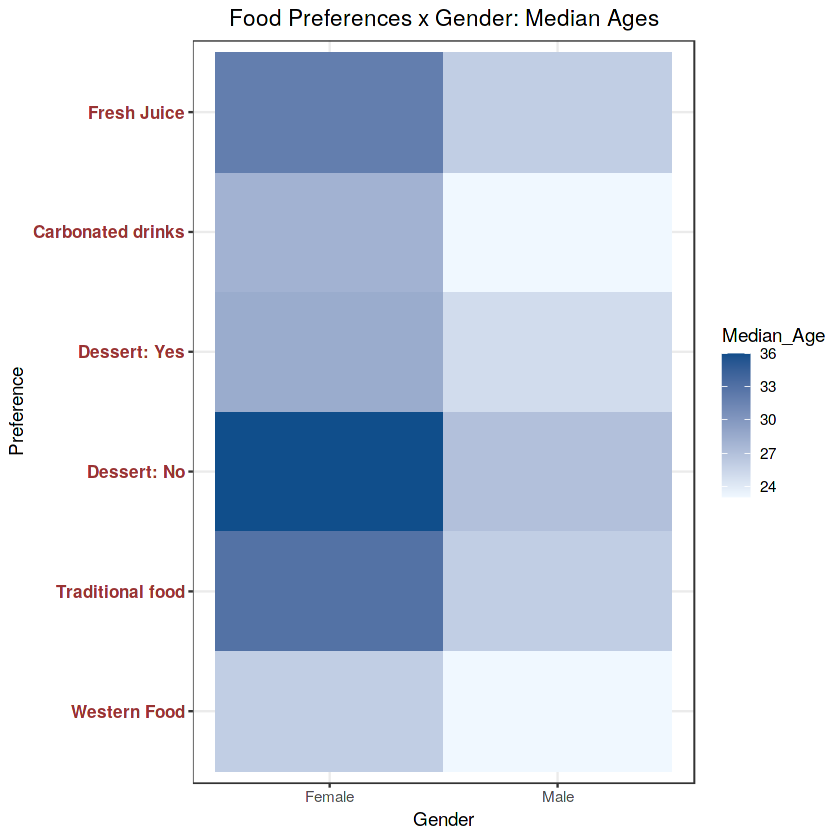

In [16]:
tibble_D <- foodpref %>%
        group_by(Gender, Dessert) %>%
        summarise(Median_Age = median(Age)) %>%
        rename(Pref = Dessert) %>% 
        filter(Pref == c("Yes", "No")) %>%
        mutate_if(is.character, stringr::str_replace_all, pattern = 'Yes', replacement = 'Dessert: Yes') %>% 
        mutate_if(is.character, stringr::str_replace_all, pattern = 'No', replacement = 'Dessert: No')
# --> Dropped "Maybe" response from Dessert because it's equivocal. Want only "Yes" and "No" for the heatmap.

tibble_F <- foodpref %>%
        group_by(Gender, Food) %>%
        summarise(Median_Age = median(Age)) %>%
        rename(Pref = Food)

tibble_J <- foodpref %>%
        group_by(Gender, Juice) %>%
        summarise(Median_Age = median(Age))  %>%
        rename(Pref = Juice)

# Combine tibbles:
AgePref_tibble <- rbind(tibble_D, tibble_F, tibble_J)

# Generate heatmap:
ggplot(AgePref_tibble, aes(y = Pref, x = Gender, fill= Median_Age)) + 
        geom_tile() + 
        theme_bw() +
        scale_fill_gradient(low = "aliceblue",
                            high = "dodgerblue4") +
        theme(axis.text.y = (element_text(hjust = 1, face = "bold", 
                                          color = "#993333", size = 10)), 
              plot.title = element_text(hjust = 0.5)) +
        scale_y_discrete(name ="Preference", 
                         limits=c("Western Food","Traditional food", 
                                  "Dessert: No", "Dessert: Yes", 
                                  "Carbonated drinks", "Fresh Juice")) +
        ggtitle(label = "Food Preferences x Gender: Median Ages")

# Machine Learning - Random Forest Classification

The objective here is to predict food preference -- **Western** or **Traditional** -- using all other variables in the data set as predictors. Toward that end, we will fit a *random forest* model with **Food** as the target variable.

This dataset contains several categorical variables. These must be converted to factors so they can be properly handled by the modeling algorithm.

The **train** function in ****caret**** will create dummy variables for these factors automatically. A separate One-Hot Encoding procedure is unnecessary. 

In [17]:
# Clone the foodpref dataframe so that it can be modified without altering the master copy:

foodpref_m <- foodpref

# Consolidate non-Indian nationalities into one class:
foodpref_m$Nationality[grep(pattern = "Indian", invert = TRUE, x = foodpref$Nationality)] <- "Non_Indian"

# Confirm the change:
foodpref_m %>% count(Nationality, sort = TRUE)

# Convert all the categorical variables to factors:

foodpref_m$Gender <- as.factor(foodpref_m$Gender)

foodpref_m$Nationality <- as.factor(foodpref_m$Nationality)

foodpref_m$Dessert <- as.factor(foodpref_m$Dessert)

# $Food and $Juice entries require special handling:
foodpref_m$Food <- make.names(foodpref_m$Food, unique = FALSE)
foodpref_m$Food <- as.factor(foodpref_m$Food)

foodpref_m$Juice <- make.names(foodpref_m$Juice, unique = FALSE)
foodpref_m$Juice <- as.factor(foodpref_m$Juice)

Nationality,n
<chr>,<int>
Indian,238
Non_Indian,46


In [18]:
# # Create a 60/40% training/test data split.
# # Our data has a class imbalance wrt to the Food category. We will use the createDataPartition function to try to preserve the overall class distribution of our data.

set.seed(3456)
trainIndex <- createDataPartition(foodpref_m$Food, p = .6, 
                                  list = FALSE, 
                                  times = 1)

foodpref_Train <- foodpref_m[as.vector(trainIndex),]
foodpref_Test  <- foodpref_m[-as.vector(trainIndex),]

# # We will train a random forest model using 5 cross-validation as the resampling method.
# # Without knowing the optimal tuning parameters, we will rely on caret's Random Hyperparameter Search (search = 'random')

fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 5,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary,
                           search = "random",
                           savePredictions = "all")

# # The tuneLength argument to the train function specifies the number of unique random tuning parameter combinations.

set.seed(6245)
fp_model <- train(Food ~ ., data = foodpref_Train, 
                 method = "ranger",
                 metric = "Spec",
                 tuneLength = 35,
                 trControl = fitControl)



#### The model has been fit. But how did it perform on the training data? And how well does it generalize to out-of-sample data?

#### Let's evaluate some performance metrics:

Confusion Matrix and Statistics

                  Reference
Prediction         Traditional.food Western.Food
  Traditional.food               88           12
  Western.Food                    5            8
                                          
               Accuracy : 0.8496          
                 95% CI : (0.7701, 0.9099)
    No Information Rate : 0.823           
    P-Value [Acc > NIR] : 0.2745          
                                          
                  Kappa : 0.4014          
                                          
 Mcnemar's Test P-Value : 0.1456          
                                          
            Sensitivity : 0.4000          
            Specificity : 0.9462          
         Pos Pred Value : 0.6154          
         Neg Pred Value : 0.8800          
             Prevalence : 0.1770          
         Detection Rate : 0.0708          
   Detection Prevalence : 0.1150          
      Balanced Accuracy : 0.6731          
                  

Setting direction: controls < cases




Call:
roc.default(response = foodpref_Test$Food, predictor = predict(fp_model,     foodpref_Test, type = "prob")[, 1], levels = rev(levels(foodpref_Test$Food)))

Data: predict(fp_model, foodpref_Test, type = "prob")[, 1] in 20 controls (foodpref_Test$Food Western.Food) < 93 cases (foodpref_Test$Food Traditional.food).
Area under the curve: 0.7444

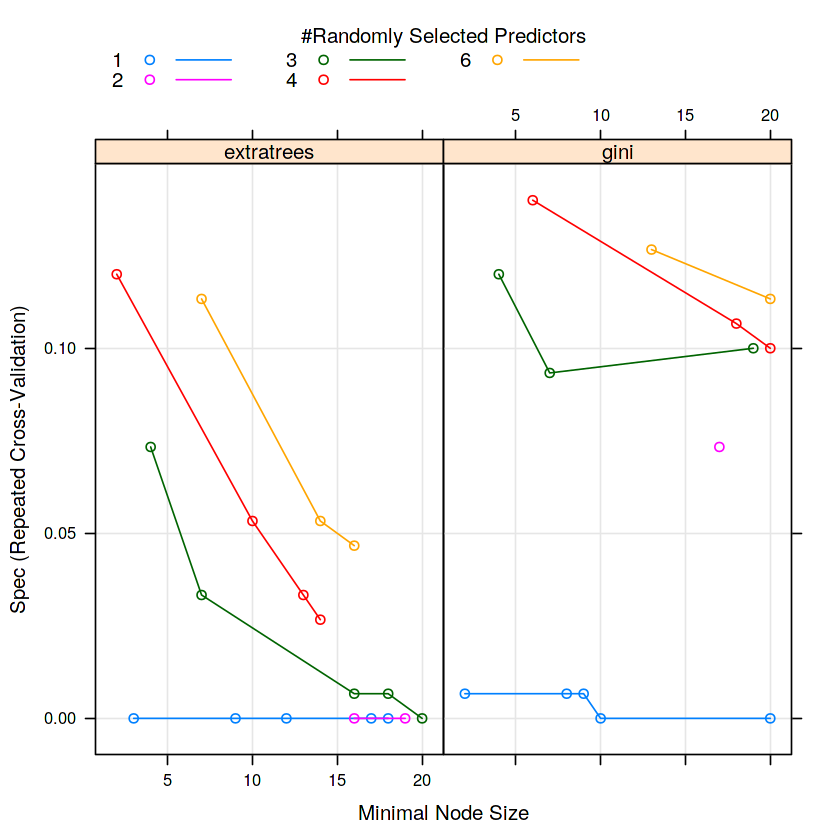

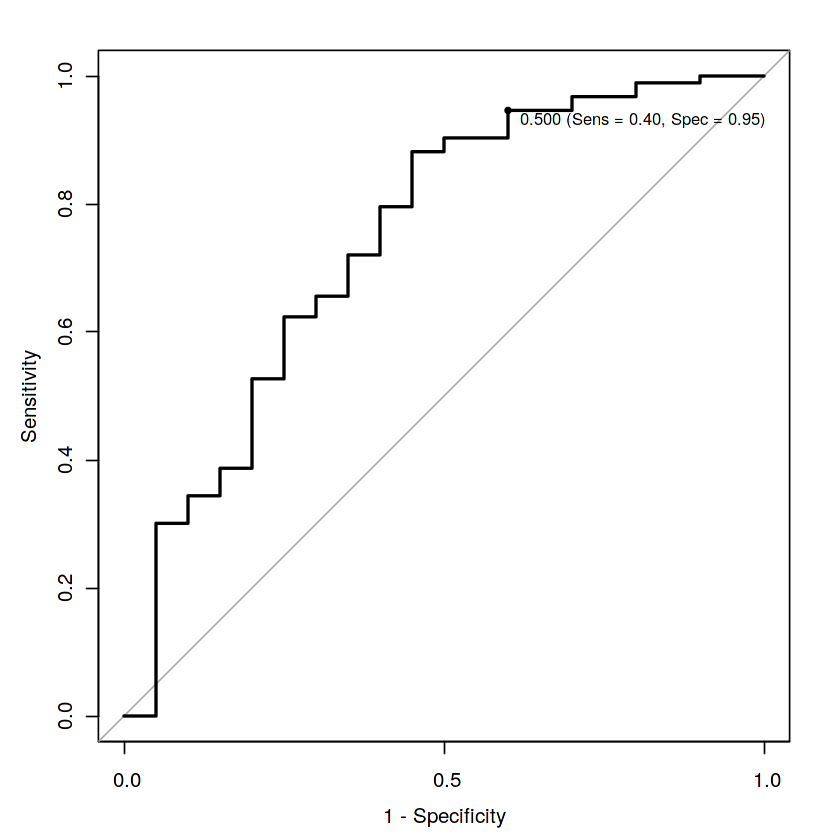

In [19]:
# # View model performance metrics wrt the training data:

plot(fp_model)

# # Evaluate the model's performance on the out-of-sample test data, using a confusion matrix:

p <- predict(fp_model,foodpref_Test)

confusionMatrix(data = p, reference = foodpref_Test$Food, positive="Western.Food")

# # Examine the ROC curve:
roc0 <- roc(foodpref_Test$Food, 
            predict(fp_model, foodpref_Test, type = "prob")[,1], 
            levels = rev(levels(foodpref_Test$Food)))
roc0

plot(roc0, print.thres = c(.5), type = "S",
     print.thres.pattern = "%.3f (Sens = %.2f, Spec = %.2f)",
     print.thres.cex = .8, 
     legacy.axes = TRUE)

### Can this model be relied on to predict preference for Western food vs Traditional food?

### Important metrics to consider are the ***specificity***, ***sensitivity***, ***accuracy***, and ***No Information Rate***.

### The specificity is high (0.95) but sensitivity is low (0.40). The accuracy is only slightly better than the No Information Rate.

Warning message in .fun(piece, ...):
“The following columns have missing values (NA), which have been removed: 'Neg Pred Value'.
”
Warning message in .fun(piece, ...):
“The following columns have missing values (NA), which have been removed: 'Neg Pred Value'.
”
Warning message in .fun(piece, ...):
“The following columns have missing values (NA), which have been removed: 'Pos Pred Value', 'Precision', 'F1'.
”


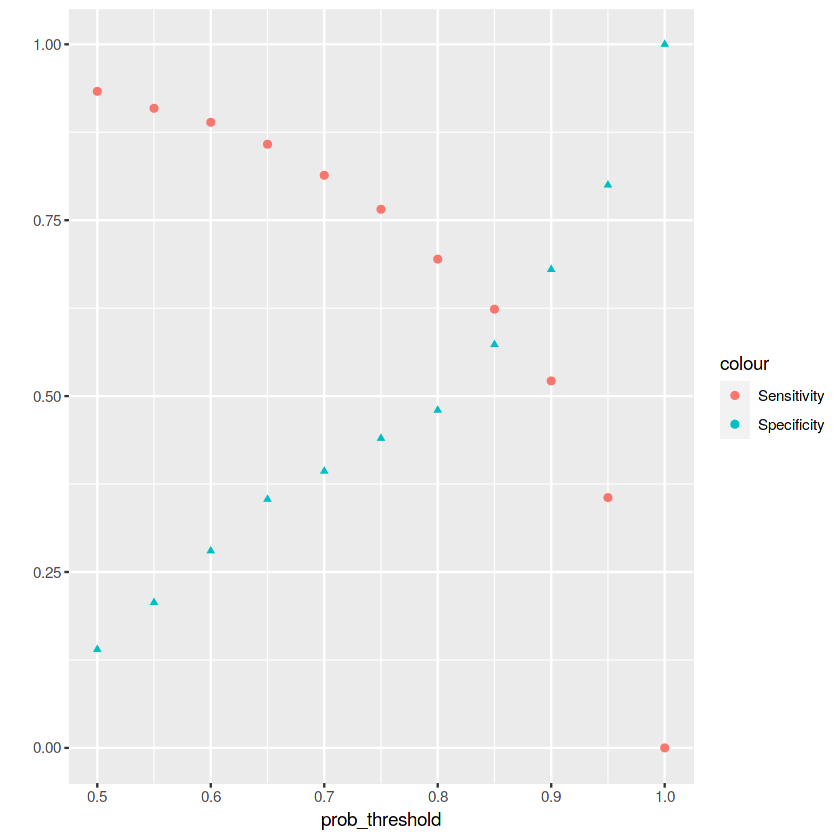

In [20]:
# # The above performance metrics are based on a probability threshold of 0.5. 
# # Let's use the thresholder function to generate performance statistics over a set of probability thresholds.

resample_stats <- thresholder(fp_model, 
                              threshold = seq(.5, 1, by = 0.05), 
                              final = TRUE)

ggplot() +
        geom_point(aes(x = prob_threshold,y = Sensitivity, colour = 'Sensitivity'),data=resample_stats) +
        geom_point(aes(x = prob_threshold,y = Specificity, colour = 'Specificity'),data=resample_stats,shape = 17) +
        xlab(label = 'prob_threshold') +
        ylab(label = '')

The graph indicates that increasing the probability cut-off to ~ 0.85 would improve the model's ***specificity*** but would result in a great loss in ***sensitivity***. This model could benefit from further parameter tuning and optimization.

### Please upvote if you found this notebook instructive, informative, or otherwise helpful.